In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary


from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

from vae import Flatten, UnFlatten, VAE

In [ ]:
#!python Train.py

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
import torch.nn as nn

In [ ]:
class Latent_Discriminator(nn.Module):
  def __init__(self, latent_size):
    super(Latent_Discriminator, self).__init__()
    self.disc = nn.Sequential(
      # Input: N x channels_img x 64 x 64
      nn.Conv2d(
        latent_size, latent_size*2, kernel_size=4, stride=2, padding=2
      ),
      nn.LeakyReLU(0.2),
      self._block(latent_size*2, latent_size*2, 4, 2, 2), # 16 x 16
      self._block(latent_size*2, latent_size*2, 4, 2, 2), # 8 x 8
      self._block(latent_size*2, latent_size*2, 4, 2, 2), # 4 x 4
      nn.Conv2d(latent_size*2, 1, kernel_size=4, stride=2, padding=2), # 1 x 1
            
    )

  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
      nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        bias=False,
      ),
      nn.BatchNorm2d(out_channels), #LayerNorm <==> Instance Norm
      nn.LeakyReLU(0.2),
      
    )

  def forward(self, x):
    return self.disc(x)

In [ ]:
class Latent_Generator(nn.Module):
  def __init__(self, z_dim, latent_size):
    super(Latent_Generator, self).__init__()
    self.gen = nn.Sequential(
      # Input: N x z_dim x 1 x 1
      self._ct_block(z_dim, latent_size*2, 4, 1, 0), # N x f_g*16 x 4 x 4
      self._ct_block(latent_size*2, latent_size*2, 4, 1, 0), # 8 x 8
      self._ct_block(latent_size*2, latent_size*2, 4, 1, 0), #16 x 16
      self._c_block(latent_size*2, latent_size, 4, 2, 0), #32 x 32
      nn.Conv2d(
        latent_size, latent_size, kernel_size=4, stride=2, padding=0,
    ),
    nn.Tanh(), #[-1, 1] 

    )

  def _ct_block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
      nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        bias=False,
      ),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),

    )

  def _c_block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
      nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        bias=False,
      ),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),

    )


  def forward(self, x):
    return self.gen(x)

In [ ]:
class Poly_GeneratorL3(nn.Module):
  def __init__(self, d, k, o):
    super(Poly_GeneratorL3, self).__init__()
    self.layer_U1 = nn.Linear(d, k, bias=False)
    self.layer_U2 = nn.Linear(d, k, bias=False)
    self.layer_U3 = nn.Linear(d, k, bias=False)
    self.layer_C = nn.Linear(k, o)
   #[-1, 1] 


  def forward(self, z):
    out_U1 = self.layer_U1(z)
    out_U2 = self.layer_U2(z)
    out_U3 = self.layer_U3(z)
    out_U12 = out_U1*out_U2
    in_U3 = out_U1 + out_U12
    in_C = out_U3*in_U3 + in_U3
    x = self.layer_C(in_C)
    return x

In [ ]:
class Poly_GeneratorC3(nn.Module):
  def __init__(self, d, k, o):
    super(Poly_GeneratorC3, self).__init__()
    self.layer_U1 = nn.Conv2d(d, k, kernel_size=4, stride=2, padding=2, bias=False)
    self.layer_U2 = nn.Conv2d(d, k, kernel_size=4, stride=2, padding=2, bias=False)
    self.layer_U3 = nn.Conv2d(d, k, kernel_size=4, stride=2, padding=2, bias=False)
    self.layer_C = nn.Conv2d(k, o, kernel_size=4, stride=2, padding=2, bias=True)
   #[-1, 1] 


  def forward(self, z):
    out_U1 = self.layer_U1(z)
    out_U2 = self.layer_U2(z)
    out_U3 = self.layer_U3(z)
    out_U12 = out_U1*out_U2
    in_U3 = out_U1 + out_U12
    in_C = out_U3*in_U3 + in_U3
    x = self.layer_C(in_C)
    return x

In [ ]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader 
from torch.utils.data import TensorDataset
from tqdm.notebook import tqdm

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
latent_vectors = torch.load('/content/latent_vectors_final.pt').to(device)

In [ ]:
torch.cuda.empty_cache() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
#IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 128
NUM_EPOCHS = 5
FEATURES_DISC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 2
#WEIGHT_CLIP = 0.01
LAMBDA_GP = 10
latent_size = 256

In [ ]:
noise = torch.randn((20, Z_DIM, 1, 1)).to(device)
gen = Poly_GeneratorC3(Z_DIM, latent_size, latent_size).to(device)
out = gen(noise)

In [ ]:
#gen = Latent_Generator(Z_DIM, latent_size).to(device)
gen = Poly_GeneratorC3(Z_DIM, latent_size, latent_size).to(device)
critic = Latent_Discriminator(latent_size).to(device)
#initialize_weights(gen)
#initialize_weights(critic)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
#criterion = nn.BCELoss()

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

gen.train()
critic.train()

Latent_Discriminator(
  (disc): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
  )
)

In [ ]:
#opt_gen = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
#opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

In [ ]:
latent_vectors = latent_vectors.view(latent_vectors.shape[0], latent_vectors.shape[1], 1, 1)

In [ ]:
dataset = TensorDataset(latent_vectors)

In [ ]:
train_dl = DataLoader(latent_vectors, BATCH_SIZE, shuffle=True, num_workers=0)

In [ ]:
from utils import gradient_penalty
from Model import Discriminator, Generator, initialize_weights
torch.cuda.empty_cache() 
initialize_weights(gen)
initialize_weights(critic)

Success


In [ ]:
for epoch in range(NUM_EPOCHS):
    for real in tqdm(train_dl):
        real = real.to(device)


        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn((real.shape[0], Z_DIM, 1, 1)).to(device)
            fake = gen(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            gp = gradient_penalty(critic, real, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP*gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

            #for p in critic.parameters():
                #p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)

        ### Train Generator: min -E[critic(gen_fake)]
        output = critic(fake).reshape(-1)
        loss_gen = -torch.mean(output)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        
    print(f"Epoch [{epoch}/{NUM_EPOCHS}]  \
                    Loss D: {loss_critic: .4f}, loss G: {loss_gen: .4f}"
            )

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [0/5]                      Loss D:  2.7121, loss G: -0.0261


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [1/5]                      Loss D:  6.2117, loss G:  0.9601


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [2/5]                      Loss D:  3.9761, loss G:  1.3838


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [3/5]                      Loss D:  4.2742, loss G:  1.9649


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [4/5]                      Loss D:  2.4341, loss G:  2.1930


In [ ]:
# Save the model checkpoints 
torch.save(gen.state_dict(), 'WGEN.pth')
torch.save(critic.state_dict(), 'WCritic.pth')

In [ ]:
from google.colab import files
files.download('WGEN.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('WCritic.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
image_channels = 3
model_load = VAE(image_channels=image_channels).to(device)
model_load.load_state_dict(torch.load('/content/animefacedataVAE.torch', map_location=torch.device('cuda')))

<All keys matched successfully>

In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [ ]:
image_channels = 3
VAE_model = VAE(image_channels=image_channels).to("cuda")
VAE_model.load_state_dict(torch.load('/content/animefacedataVAE.torch', map_location=torch.device('cuda')))

<All keys matched successfully>

In [ ]:
input = torch.randn(3, Z_DIM, 1, 1).to(device)
latent_gen = gen(input)

In [ ]:
latent_gen.shape

torch.Size([3, 256, 1, 1])

In [ ]:
latent_gen = latent_gen.view(latent_gen.shape[0], latent_gen.shape[1])

In [ ]:
latent_gen.shape

torch.Size([3, 256])

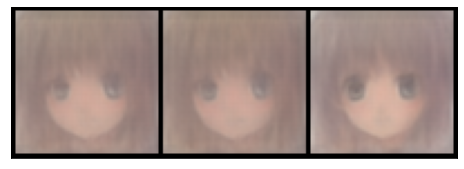

In [ ]:
generated_image1 = VAE_model.decoder(VAE_model.fc3(latent_gen)).to(device)
#generated_image2=model_load.decoder(h)
show_images(generated_image1.to('cpu'))